In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import keras
import numpy as np
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.utils import pad_sequences

In [3]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [5]:
final_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [6]:
final_df.drop(['date_column.2', 'ppid.2', 'date_column.1', 'ppid.1'], axis=1, inplace=True)

In [7]:
final_df['date_column'] = pd.to_datetime(final_df['date_column'])

In [9]:
import pandas as pd
from sklearn.utils import resample

# Separate the majority (negative) and minority (positive) classes
negative_cases = final_df[final_df['blood_culture_test_encoded'] == 0.0]
positive_cases = final_df[final_df['blood_culture_test_encoded'] == 1.0]

# Ensure each patient has only one test by dropping duplicates based on patient ID (assuming 'ppid' is the patient ID column)
negative_cases_unique = negative_cases.drop_duplicates(subset='ppid')
positive_cases_unique = positive_cases.drop_duplicates(subset='ppid')

# Downsample the cases to get 500 unique patients/tests in each class
negative_downsampled = resample(negative_cases_unique,
                                replace=False,  # sample without replacement
                                n_samples=500,  # number of samples to match
                                random_state=42)  # reproducibility

positive_downsampled = resample(positive_cases_unique,
                                replace=False,  # sample without replacement
                                n_samples=500,  # number of samples to match
                                random_state=42)  # reproducibility

# Combine the downsampled negative and positive cases
balanced_data = pd.concat([negative_downsampled, positive_downsampled])

# Shuffle the resulting dataset to mix positive and negative cases
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest


# Replace 'target_column' with the name of your target variable column
target_column = 'blood_culture_test_encoded'  # Change this to your actual target column name

# Drop the date column - replace 'date_column' with your actual date column name
X = balanced_data.drop([target_column, 'date_column', 'ppid'], axis=1)
y = balanced_data[target_column]
feature_names = list(X.columns)

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=False)


scaler = StandardScaler().fit(X_train_xgb)
X_train_xgb_2d = scaler.transform(X_train_xgb)
X_test_xgb_2d = scaler.transform(X_test_xgb)

# Fill NaN values, if they exist
X_train_xgb_2d = np.nan_to_num(X_train_xgb_2d)
X_test_xgb_2d = np.nan_to_num(X_test_xgb_2d)

# For example:
iso_forest = IsolationForest(n_estimators=100, random_state=42, contamination='auto')
iso_forest.fit(X_train_xgb_2d[y_train_xgb == 0])  # Assuming y_train_xgb is your target variable for XGBoost

# Compute anomaly scores for each subset using the same Isolation Forest model
anomaly_scores_train_xgb = iso_forest.decision_function(X_train_xgb_2d)
anomaly_scores_test_xgb = iso_forest.decision_function(X_test_xgb_2d)

# Normalize the anomaly scores
anomaly_scores_train_xgb_norm = np.interp(anomaly_scores_train_xgb, (anomaly_scores_train_xgb.min(), anomaly_scores_train_xgb.max()), (0, 1))
anomaly_scores_test_xgb_norm = np.interp(anomaly_scores_test_xgb, (anomaly_scores_test_xgb.min(), anomaly_scores_test_xgb.max()), (0, 1))

# Append anomaly scores to the original 2D data
X_train_xgb_extended = np.concatenate((X_train_xgb_2d, anomaly_scores_train_xgb_norm.reshape(-1, 1)), axis=1)
X_test_xgb_extended = np.concatenate((X_test_xgb_2d, anomaly_scores_test_xgb_norm.reshape(-1, 1)), axis=1)

feature_names.append('anomaly_score')
class_ratio = sum(y_train_xgb == 0) / sum(y_train_xgb == 1)

# Now, X_train_xgb_extended and X_test_xgb_extended are ready for training with XGBoost


In [11]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(scale_pos_weight=class_ratio, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_xgb_extended, y_train_xgb)
y_pred_xgb = xgb_model.predict(X_test_xgb_extended)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:40:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [12]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(scale_pos_weight=class_ratio)
lgb_model.fit(X_train_xgb_extended, y_train_xgb)
y_pred_lgb = lgb_model.predict(X_test_xgb_extended)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 401, number of negative: 399
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 103
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501250 -> initscore=0.005000
[LightGBM] [Info] Start training from score 0.005000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [13]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.7 MB/s eta 0:00:00


In [14]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(scale_pos_weight=class_ratio, verbose=0)
cat_model.fit(X_train_xgb_extended, y_train_xgb)
y_pred_cat = cat_model.predict(X_test_xgb_extended)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model_nn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_xgb_extended.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_nn.fit(X_train_xgb_extended, y_train_xgb, epochs=10, batch_size=32)
y_pred_nn = model_nn.predict(X_test_xgb_extended)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5410 - loss: 0.7053
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7376 - loss: 0.5363
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7999 - loss: 0.4707
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8069 - loss: 0.4330
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8255 - loss: 0.3748
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8703 - loss: 0.3201
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8888 - loss: 0.2985
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8894 - loss: 0.2712
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9153 - loss: 0.2346
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9397 - loss: 0.1872
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


In [16]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train_xgb_extended, y_train_xgb)
y_pred_log = log_reg.predict(X_test_xgb_extended)


In [17]:
from sklearn.ensemble import RandomForestClassifier

# Create the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_xgb_extended, y_train_xgb)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_xgb_extended)


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, average_precision_score


In [19]:
def evaluate_model(y_true, y_pred, y_scores):
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)  # same as sensitivity
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_scores)
    auprc = average_precision_score(y_true, y_scores)

    # Calculate specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"AUPRC Score: {auprc:.4f}")

In [ ]:
combined_predictions = np.round((y_pred_xgb + y_pred_lgb + y_pred_cat) / 3).astype(int)


In [20]:
y_scores_xgb = xgb_model.predict_proba(X_test_xgb_extended)[:, 1]
y_scores_lgb = lgb_model.predict_proba(X_test_xgb_extended)[:, 1]
y_scores_cat = cat_model.predict_proba(X_test_xgb_extended)[:, 1]
y_scores_rf = rf_model.predict_proba(X_test_xgb_extended)[:, 1]
y_scores_nn = model_nn.predict(X_test_xgb_extended).ravel()
y_scores_log = log_reg.predict_proba(X_test_xgb_extended)[:, 1]

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [21]:

print("\nLightGBM Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_lgb, y_scores_lgb)

print("\nCatBoost Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_cat, y_scores_cat)

# For Neural Network, convert predictions to binary first (assuming threshold of 0.5)
y_pred_nn_binary = np.round(y_pred_nn).astype(int).flatten()
print("\nNeural Network Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_nn_binary, y_scores_nn)

print("\nLogistic Regression Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_log, y_scores_log)


print("\nRandom Forest Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_rf, y_scores_rf)


print("XGBoost Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_xgb, y_scores_xgb)

print("\nLogistic Regression Model Evaluation:")
evaluate_model(y_test_xgb, y_pred_log, y_scores_log)




LightGBM Model Evaluation:
Accuracy: 0.6700
Precision: 0.6813
Recall (Sensitivity): 0.6263
Specificity: 0.7129
F1 Score: 0.6526
ROC AUC Score: 0.7667
AUPRC Score: 0.7737

CatBoost Model Evaluation:
Accuracy: 0.7150
Precision: 0.7283
Recall (Sensitivity): 0.6768
Specificity: 0.7525
F1 Score: 0.7016
ROC AUC Score: 0.8200
AUPRC Score: 0.8308

Neural Network Model Evaluation:
Accuracy: 0.7200
Precision: 0.7312
Recall (Sensitivity): 0.6869
Specificity: 0.7525
F1 Score: 0.7083
ROC AUC Score: 0.7820
AUPRC Score: 0.7604

Logistic Regression Model Evaluation:
Accuracy: 0.6800
Precision: 0.6733
Recall (Sensitivity): 0.6869
Specificity: 0.6733
F1 Score: 0.6800
ROC AUC Score: 0.7716
AUPRC Score: 0.7584

Random Forest Model Evaluation:
Accuracy: 0.6700
Precision: 0.6941
Recall (Sensitivity): 0.5960
Specificity: 0.7426
F1 Score: 0.6413
ROC AUC Score: 0.7561
AUPRC Score: 0.7615
XGBoost Model Evaluation:
Accuracy: 0.6850
Precision: 0.7045
Recall (Sensitivity): 0.6263
Specificity: 0.7426
F1 Score: 0.6

In [28]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 17.6 MB/s eta 0:00:00


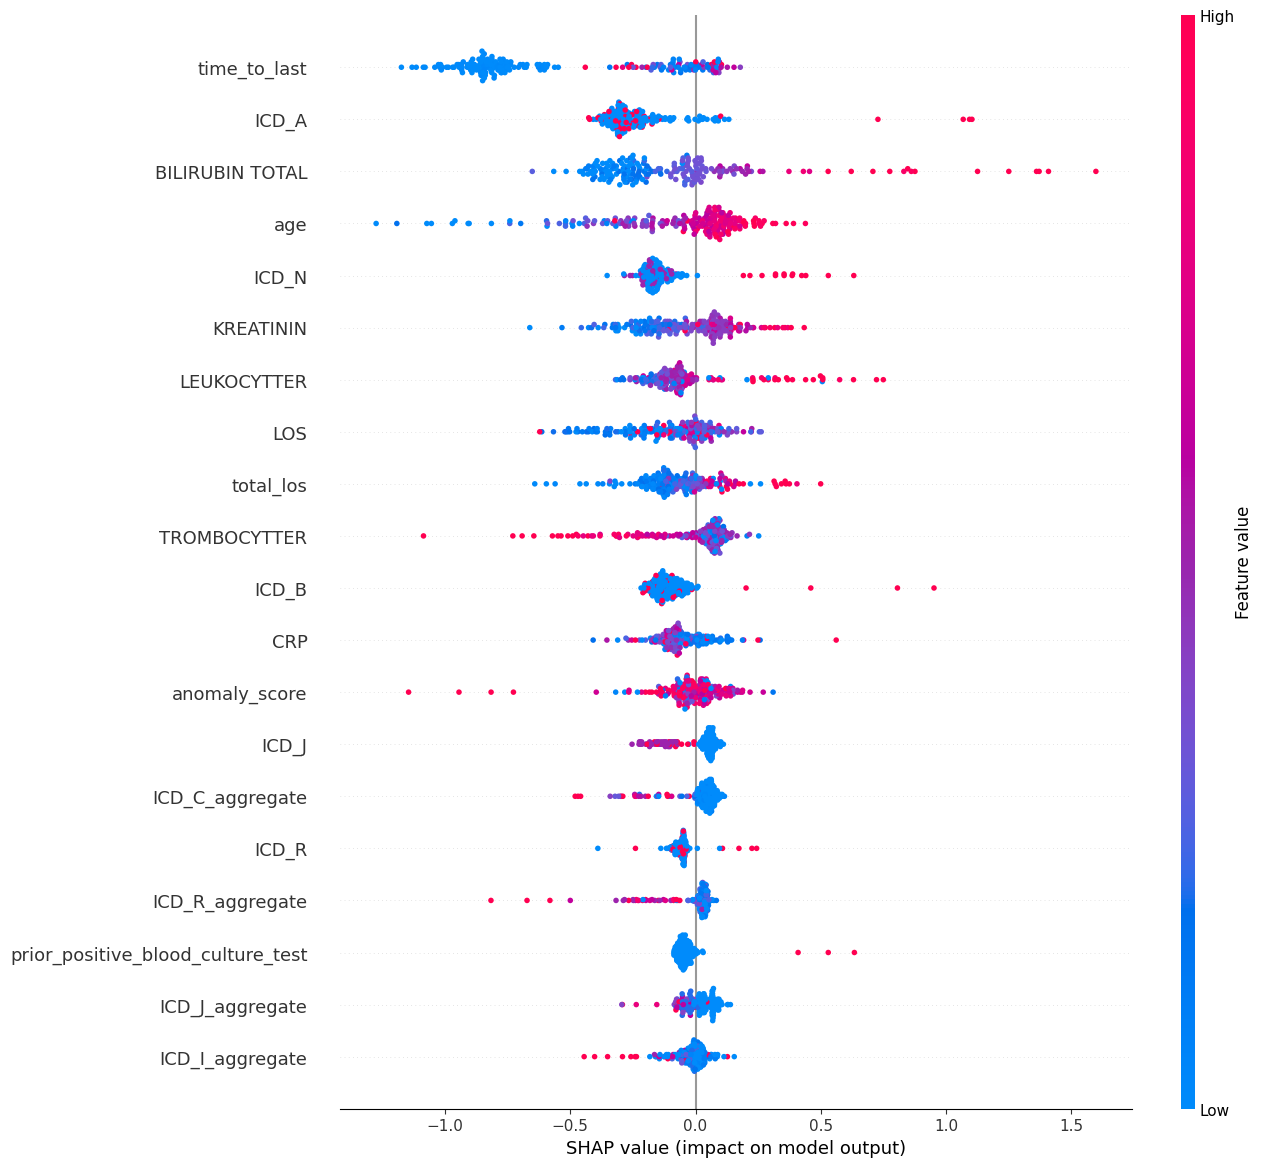

In [29]:
import shap
import matplotlib.pyplot as plt

# Generate SHAP values
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_xgb_extended)


# Plot SHAP summary dot plot
shap.summary_plot(shap_values, features=X_test_xgb_extended, feature_names=feature_names, show = False,)
# Save the plot as a high-quality PNG file
plt.gcf().set_size_inches(18, 12)  # Adjust the size as needed

plt.savefig("shap_summary_plot.png", bbox_inches='tight', dpi=300)

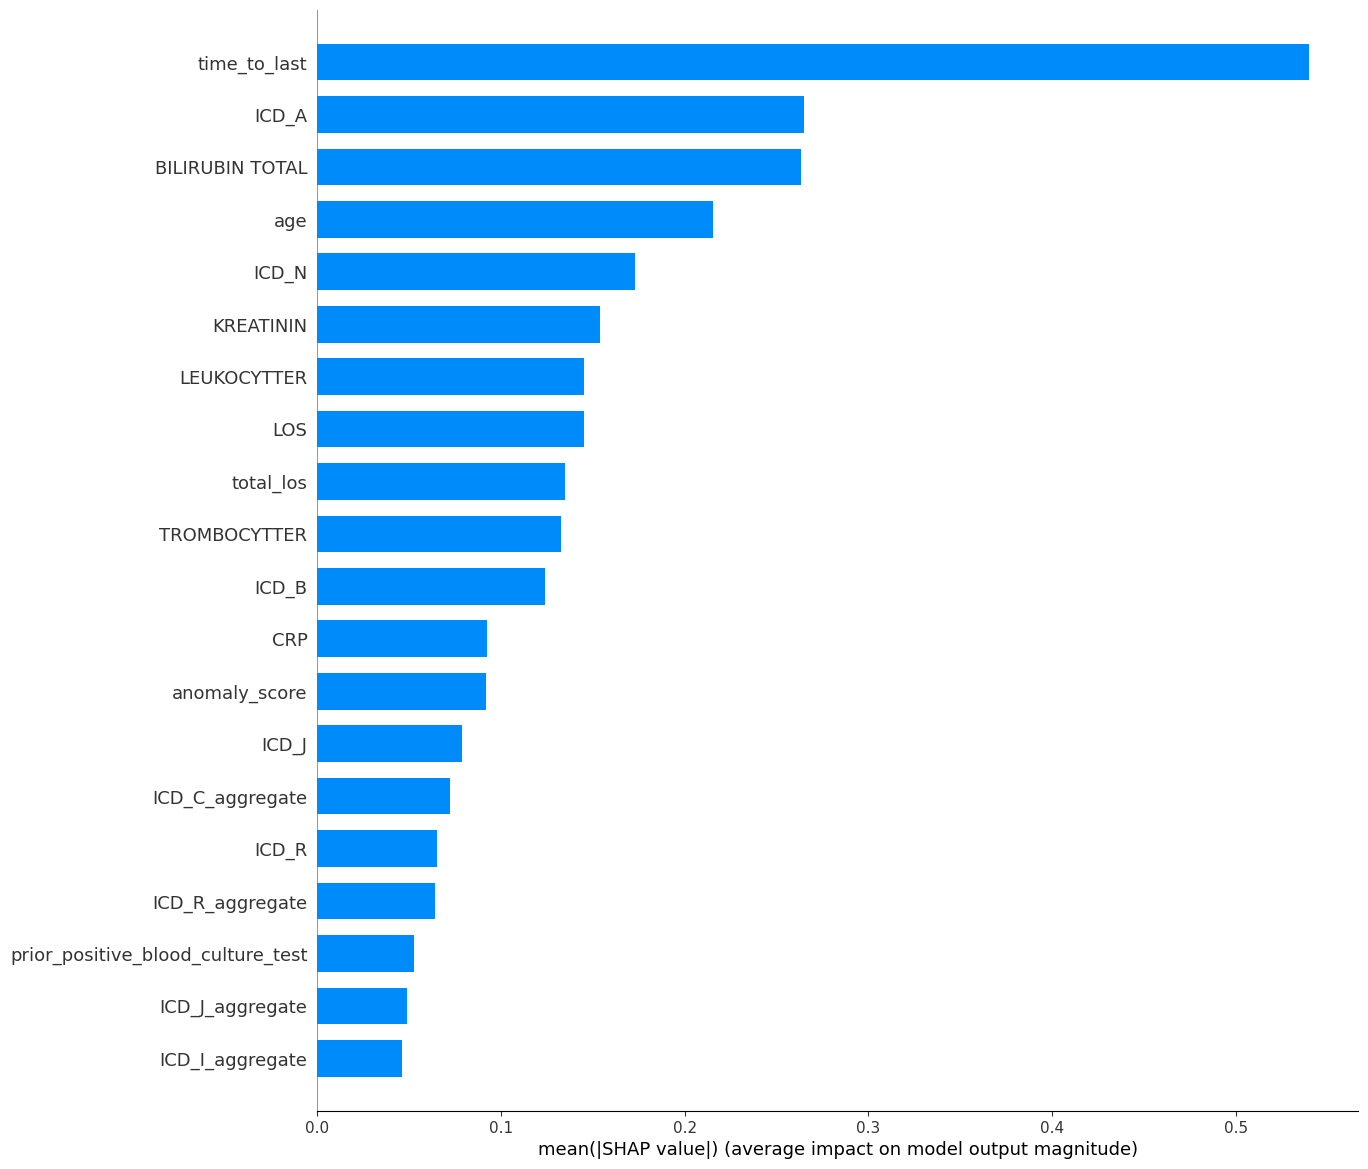

In [30]:
# Plot SHAP summary dot plot
shap.summary_plot(shap_values, plot_type = 'bar', features=X_test_xgb_extended, feature_names=feature_names, show = False,)
# Save the plot as a high-quality PNG file
plt.gcf().set_size_inches(18, 12)  # Adjust the size as needed

plt.savefig("shap_summary_plot_bar.png", bbox_inches='tight', dpi=300)